# Tutorial1: 房价预测

本节旨在通过 [kaggle 房价预测竞赛](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) 这一简单案例展示如何使用全连接神经网络解决回归问题。

分以下几步来实现：
1. 环境安装
2. 分步运行本文件

    2.1 数据加载和预处理

    2.2 构建网络

    2.3 训练与评估模型


## 1. 环境安装
 
我们默认用户已经按照 [tutorial_scow_for_ai](../tutorial_scow_for_ai.md) 在 “交互式应用” 中创建了  Jupyter Lab 应用，并已经安装了 conda。现在需要在命令行中创建环境并注册 ipykernal：

```bash
conda create -n tutorial1 python=3.9
conda activate tutorial1
# 安装内核
conda install ipykernel
# 注册内核
python -m ipykernel install --user --name=tutorial1 --display-name="tutorial1"

pip install torch==2.1.0 numpy==1.26.4 matplotlib==3.8.4 pandas==2.2.2 scikit-learn==1.5.0

# 查看已注册的内核
jupyter kernelspec list
```

（ pytorch 版本需与 cuda 版本对应，请查看版本对应网站：https://pytorch.org/get-started/previous-versions ，通过 nvidia-smi 命令可查看 cuda 版本）

选择本 ipynb 文件的 kernel 为 'tutorial1', 硬件资源建议使用1张GPU运行。

CUDA Version: 12.1; Torch Version: 2.1.0

## 2. 分步运行本文件

## 2.1 数据预处理
作为简化模型的案例，这里使用的是 [kaggle 房价预测竞赛中的训练数据集](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data)。在后面的处理中，我们只使用了数值部分的特征，并把全部数据分为训练集和测试集两部分。

实验所用数据: [train.csv](./data/train.csv)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch_npu

# 读取数据
# VAR_PLACEHOLDER
data = pd.read_csv('./data/train.csv')

# 去掉第一列编号
data = data.iloc[:, 1:]

# 只保留数值类型的数据
numeric_features = data.select_dtypes(include=[np.number])

# 处理缺失值
numeric_features.fillna(numeric_features.mean(), inplace=True)

# 分离特征和目标变量
X = numeric_features.drop('SalePrice', axis=1).values
y = numeric_features['SalePrice'].values

# 切分数据为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# 标准化特征
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# 转换为torch张量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
y_test = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

### 2.2 构建模型

使用一个全连接层加 relu 激活层作为示例，更复杂的网络可以通过修改 Net 类来实现。

In [2]:
import torch.nn as nn

class Net(nn.Module):
    def __init__(self, input_features):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_features, 128)
        self.fc2 = nn.Linear(128, 1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x) # 回归任务不用激活函数
        return x

### 2.3 训练与评估

由于房价之间的差异巨大，评估预测是否准确时应该考虑相对值的变化，所以使用下面的评估函数：

$$
\sqrt{
    \frac{1}{n} \sum_{i=1}^{n} (\log y_i - \log \hat{y}_i)^2
}
$$

训练模型与评估模型都在这部分



In [ ]:
from torch.utils.data import DataLoader, TensorDataset

# 参数设置
learning_rate, weight_decay, epochs, batch_size = 0.1, 5, 100, 32

device = torch.device('npu:0') if torch.npu.is_available() else torch.device('cpu')
print(f"Using device: {device}")

# 实例化模型
model = Net(X_train.shape[1]).to(device)

# 损失函数
criterion = nn.MSELoss()

# 优化器
optimizer = torch.optim.Adam(model.parameters(), lr= learning_rate, weight_decay=weight_decay)

# loss 评估
def score(model, X, y):
    pred = torch.clamp(model(X), 1, float('inf'))
    score = torch.sqrt(criterion(torch.log(pred), torch.log(y)))
    
    return score.item()

# 训练模型
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

train_ls, test_ls = [], []
for epoch in range(epochs):
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, targets)
    
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # 模型评估
    model.eval()
    with torch.no_grad():
        train_ls.append(score(model, X_train.to(device), y_train.to(device)))
        test_ls.append(score(model, X_test.to(device), y_test.to(device)))

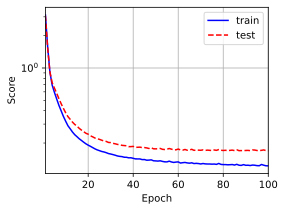

In [6]:
from matplotlib import pyplot as plt
from matplotlib_inline import backend_inline

backend_inline.set_matplotlib_formats('svg')

plt.rcParams['figure.figsize'] = (4, 3)

plt.plot(list(range(1, epochs + 1)), train_ls, 'b', label='train')
plt.plot(list(range(1, epochs + 1)), test_ls, 'r--', label='test')
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.yscale('log')
plt.xlim([1, epochs])

plt.legend()
plt.grid()

---

> 作者: 黎颖; 龙汀汀
>
> 联系方式: yingliclaire@pku.edu.cn;   l.tingting@pku.edu.cn